In [1]:
!pip install PyPDF2
!pip install python-docx
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
from PyPDF2 import PdfReader
from docx import Document
from google.colab import files
from collections import Counter
import nltk
from nltk.corpus import stopwords
from io import BytesIO
import io

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def cleanResume(txt):
    txt = txt.lower()
    txt = re.sub('http\S+\s*', ' ', txt)  # Remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # Remove RT and cc
    txt = re.sub('#\S+', ' ', txt)  # Remove hashtags
    txt = re.sub('@\S+', ' ', txt)  # Remove mentions
    txt = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', txt)
    txt = re.sub(r'[^\x00-\x7f]',r' ', txt)  # Remove non-ASCII characters
    txt = re.sub('\s+', ' ', txt)  # Remove extra whitespace

    words = txt.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(filtered_words)

def extract_text_from_file(file_path):
    text = ""
    if file_path.endswith('.pdf'):
        reader = PdfReader(file_path)
        text = " ".join(page.extract_text() for page in reader.pages if page.extract_text())
    elif file_path.endswith('.docx'):
        doc = Document(file_path)
        text = " ".join(paragraph.text for paragraph in doc.paragraphs)
    return cleanResume(text)

In [ ]:
df = pd.read_csv('//content/UpdatedResumeDataSet.csv')

In [ ]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
df.shape

(962, 2)

In [ ]:
print("Original Distribution:")
print(df['Category'].value_counts())

Original Distribution:
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


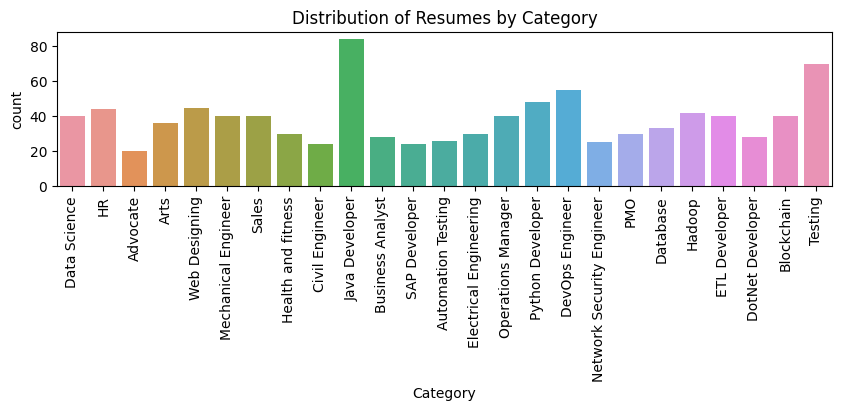

In [ ]:
#df['Category'] = df['Category'].astype('category')
plt.figure(figsize=(10, 2))
sns.countplot(data=df, x='Category')
plt.xticks(rotation=90)
plt.title('Distribution of Resumes by Category')
plt.show()

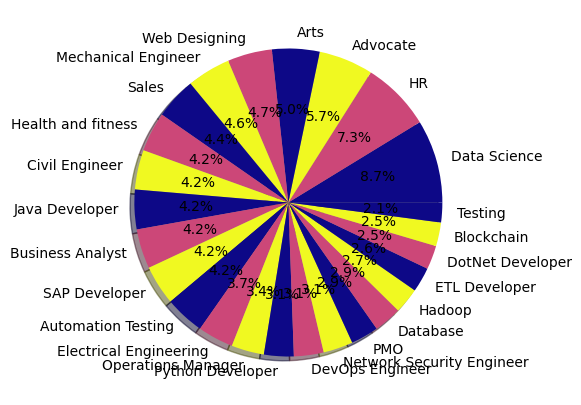

In [ ]:
counts = df['Category'].value_counts()
labels = df['Category'].unique()
plt.figure(figsize=(10,5))

#plt.pie(counts,labels=labels)
plt.pie(counts,labels=labels,autopct='%1.1f%%',shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.show()

In [ ]:
min_count = df['Category'].value_counts().min()

In [ ]:
balanced_data = pd.concat([df[df['Category'] == role].sample(min_count) for role in df['Category'].unique()])

In [ ]:
print("\nBalanced Distribution:")
print(balanced_data['Category'].value_counts())


Balanced Distribution:
Data Science                 20
Electrical Engineering       20
Blockchain                   20
DotNet Developer             20
ETL Developer                20
Hadoop                       20
Database                     20
PMO                          20
Network Security Engineer    20
DevOps Engineer              20
Python Developer             20
Operations Manager           20
Automation Testing           20
HR                           20
SAP Developer                20
Business Analyst             20
Java Developer               20
Civil Engineer               20
Health and fitness           20
Sales                        20
Mechanical Engineer          20
Web Designing                20
Arts                         20
Advocate                     20
Testing                      20
Name: Category, dtype: int64


In [ ]:
balanced_data.head()

,Category,Resume
38,Data Science,Personal Skills â¢ Ability to quickly grasp t...
29,Data Science,Expertise â Data and Quantitative Analysis â...
15,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
19,Data Science,Expertise â Data and Quantitative Analysis â...
11,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...


In [ ]:
balanced_data.shape

(500, 2)

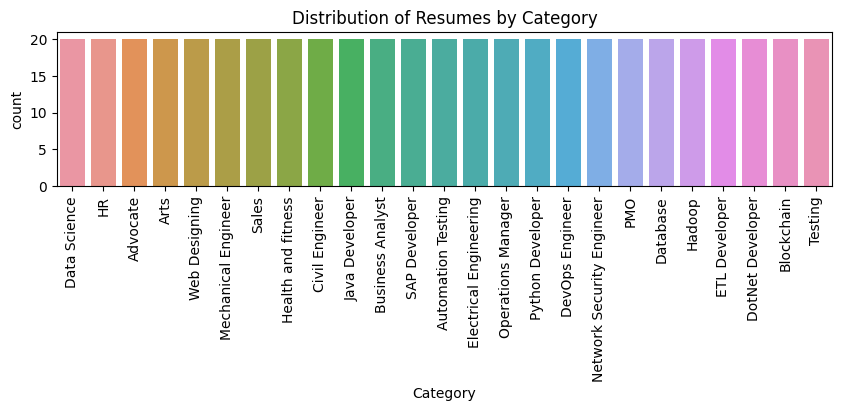

In [ ]:
#balanced_data['Category'] = balanced_data['Category'].astype('category')
plt.figure(figsize=(10, 2))
sns.countplot(data=balanced_data, x='Category')
plt.xticks(rotation=90)
plt.title('Distribution of Resumes by Category')
plt.show()

In [ ]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

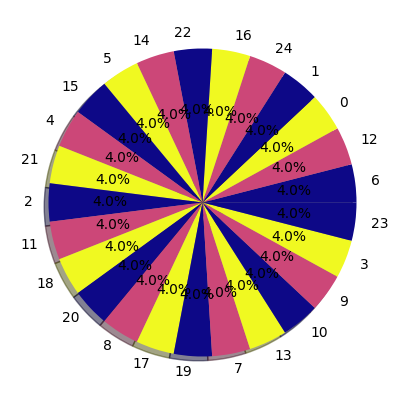

In [ ]:
counts = balanced_data['Category'].value_counts()
labels = balanced_data['Category'].unique()
plt.figure(figsize=(10,5))

#plt.pie(counts,labels=labels)
plt.pie(counts,labels=labels,autopct='%1.1f%%',shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.show()

In [ ]:
balanced_data['Category'].iloc[0]

'Data Science'

In [ ]:
balanced_data['Resume'].iloc[0]

'Personal Skills â\x9e¢ Ability to quickly grasp technical aspects and willingness to learn â\x9e¢ High energy levels & Result oriented. Education Details \r\nJanuary 2018 Master of Engineering Computer Technology & Application Bhopal, Madhya Pradesh Truba Institute of Engineering & Information Technology\r\nJanuary 2010 B.E. computer science Bhopal, Madhya Pradesh RKDF Institute of Science and Technology College of Engineering\r\nJanuary 2006 Polytechnic Information Technology Vidisha, Madhya Pradesh SATI Engineering College in Vidisha\r\nJanuary 2003 M.tech Thesis Detail  BMCH School in Ganj basoda\r\nData science \r\n\r\nI have six month experience in Data Science. Key Skills: - Experience in Machine Learning, Deep Leaning, NLP, Python, SQL, Web Scraping Good knowledge in computer subjects and ability to update\r\nSkill Details \r\nExperience in Machine Learning, Deep Learning, NLP, Python, SQL, Web Crawling, HTML,CSS.- Exprience - Less than 1 year monthsCompany Details \r\ncompany 

In [ ]:
balanced_data['Resume'] = balanced_data['Resume'].apply(lambda x: cleanResume(x))

In [ ]:
balanced_data['Resume'].iloc[0]

'personal skills ability quickly grasp technical aspects willingness learn high energy levels result oriented education details january 2018 master engineering computer technology application bhopal madhya pradesh truba institute engineering information technology january 2010 b e computer science bhopal madhya pradesh rkdf institute science technology college engineering january 2006 polytechnic information technology vidisha madhya pradesh sati engineering college vidisha january 2003 tech thesis detail bmch school ganj basoda data science six month experience data science key skills experience machine learning deep leaning nlp python sql web scraping good knowledge computer subjects ability update skill details experience machine learning deep learning nlp python sql web crawling html css exprience less 1 year monthscompany details company rnt ai technology solution description text classification using machine learning algorithms python practical knowledge deep learning algorithms 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
le.fit(balanced_data['Category'])
balanced_data['Category'] = le.transform(balanced_data['Category'])

In [ ]:
balanced_data.Category.unique()

array([ 6, 12,  0,  1, 24, 16, 22, 14,  5, 15,  4, 21,  2, 11, 18, 20,  8,
       17, 19,  7, 13, 10,  9,  3, 23])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['Resume'],  # Features (resumes)
    balanced_data['Category'],  # Target variable (job role)
    test_size=0.2,  # 80% training, 20% testing
    random_state=42)

In [ ]:
# Feature engineering and model training
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

rf_classifier = RandomForestClassifier()
ovr_classifier = OneVsRestClassifier(rf_classifier)
ovr_classifier.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [ ]:
y_pred = ovr_classifier.predict(X_test_tfidf)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       0.67      0.67      0.67         6
           7       1.00      0.60      0.75         5
           8       1.00      0.83      0.91         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       0.86      1.00      0.92         6
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.

In [ ]:
def extract_text_from_file(file_name, file_content):
    text = ""
    if file_name.endswith('.pdf'):
        reader = PdfReader(io.BytesIO(file_content))
        text = " ".join(page.extract_text() for page in reader.pages if page.extract_text())
    elif file_name.endswith('.docx'):
        doc = Document(io.BytesIO(file_content))
        text = " ".join(paragraph.text for paragraph in doc.paragraphs)
    return cleanResume(text)

In [ ]:
def predict_job_category(file_name, file_content):
    text = extract_text_from_file(file_name, file_content)
    input_features = vectorizer.transform([text])
    prediction_id = ovr_classifier.predict(input_features)[0]
    category_name = category_mapping.get(prediction_id, "Unknown Category")
    return category_name


In [ ]:
category_mapping = {
    15: "Java Developer",
    23: "Testing",
    8: "DevOps Engineer",
    20: "Python Developer",
    24: "Web Designing",
    12: "HR",
    13: "Hadoop",
    3: "Blockchain",
    10: "ETL Developer",
    18: "Operations Manager",
    6: "Data Science",
    22: "Sales",
    16: "Mechanical Engineer",
    1: "Arts",
    7: "Database",
    11: "Electrical Engineering",
    14: "Health and fitness",
    19: "PMO",
    4: "Business Analyst",
    9: "DotNet Developer",
    2: "Automation Testing",
    17: "Network Security Engineer",
    21: "SAP Developer",
    5: "Civil Engineer",
    0: "Advocate",
    }

In [ ]:
def predict_job_category(file_name, file_content):
    global category_mapping  # This line is usually not needed if category_mapping is defined globally
    text = extract_text_from_file(file_name, file_content)
    input_features = vectorizer.transform([text])
    prediction_id = ovr_classifier.predict(input_features)[0]
    category_name = category_mapping.get(prediction_id, "Unknown Category")
    return category_name

In [ ]:
# Upload files from Google Colab
num_files_to_upload = 2
uploaded_files = {}

for i in range(num_files_to_upload):
    uploaded = files.upload()
    uploaded_files.update(uploaded)
# Process each uploaded file and predict the job category
for file_name, file_content in uploaded_files.items():
    predicted_category = predict_job_category(file_name, file_content)
    print(f"File: {file_name}, Predicted Category: {predicted_category}")


Saving GANDE KAVYA.pdf to GANDE KAVYA.pdf


Saving Gande Rajesh Kumar .pdf to Gande Rajesh Kumar .pdf
File: GANDE KAVYA.pdf, Predicted Category: Web Designing
File: Gande Rajesh Kumar .pdf, Predicted Category: Testing
